## 德州扑克

探索一下德州扑克中的数字。

In [1]:
try:
    import google.colab
    import sys
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB and sys.version.startswith('3.8'):
    #install python 3.9
    !sudo apt-get update -y
    !sudo apt-get install python3.9

    #change alternatives
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

    #check python version
    !python --version
    #3.9.16

    # install pip for new python 
    !sudo apt-get install python3.9-distutils
    !wget https://bootstrap.pypa.io/get-pip.py
    !python get-pip.py

    # credit of these last two commands blongs to @Erik
    # install colab's dependencies
    !python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

    # link to the old google package
    !ln -s /usr/local/lib/python3.8/dist-packages/google \
        /usr/local/lib/python3.9/dist-packages/google

    print(f"现在重启colab，就可以使用python3.9了")

In [2]:
# 你可能需要安装这些依赖包
!pip install numpy treys matplotlib tqdm ipywidgets

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import math
import re

import matplotlib.pyplot as plt
import numpy as np
from treys.card import Card
from treys.evaluator import Evaluator
from treys.deck import Deck
from tqdm import trange

In [4]:
suits = [
    {
        "name": "spade",
        "symbol": "♠",
        "color": "black",
        "short": "s",
        "cn_name": "黑桃",
    },
    {
        "name": "heart",
        "symbol": "♥",
        "color": "red",
        "short": "h",
        "cn_name": "红桃",
    },
    {
        "name": "club",
        "symbol": "♣",
        "color": "black",
        "short": "c",
        "cn_name": "梅花",
    },
    {
        "name": "diamond",
        "symbol": "♦",
        "color": "red",
        "short": "d",
        "cn_name": "方块",
    },
]
n_suits = len(suits)
print(f"德州扑克中的花色共有{n_suits}种，分别是：")
for suit in suits:
    print(f"- {suit['symbol']} {suit['cn_name']} ({suit['name']})")

ranks = [
    {"name": "ace", "symbol": "A"},
    {"name": "king", "symbol": "K"},
    {"name": "queen", "symbol": "Q"},
    {"name": "jack", "symbol": "J"},
    {"name": "ten", "symbol": "10"},
    {"name": "nine", "symbol": "9"},
    {"name": "eight", "symbol": "8"},
    {"name": "seven", "symbol": "7"},
    {"name": "six", "symbol": "6"},
    {"name": "five", "symbol": "5"},
    {"name": "four", "symbol": "4"},
    {"name": "three", "symbol": "3"},
    {"name": "two", "symbol": "2"},
]
n_rank = len(ranks)
print()
print(f"德州扑克中的牌面共有{n_rank}种，分别是：")
for rank in ranks:
    print(f"{rank['symbol']}" + " ", end="")
print()

n_cards = n_suits * n_rank
print()
print(f"德州扑克中的扑克牌共有{n_cards}张.")

德州扑克中的花色共有4种，分别是：
- ♠ 黑桃 (spade)
- ♥ 红桃 (heart)
- ♣ 梅花 (club)
- ♦ 方块 (diamond)

德州扑克中的牌面共有13种，分别是：
A K Q J 10 9 8 7 6 5 4 3 2 

德州扑克中的扑克牌共有52张.


## 起手牌

开局每个人都会发到两张牌，这两张牌叫做起手牌。在轮到我们行动的时候，我们一般在看牌之后选择：
* 弃牌：放弃这一局
* 加注：加注，然后轮到下一个人行动
* 跟注：跟注，然后轮到下一个人行动

这时候的决策是基于我们的起手牌好坏，以及其他人的行动。这里我们先不考虑其他人的行动，只考虑我们的起手牌好坏。


### 一对一

我们可以通过模拟来估算不同起手牌的胜率，从最简单的一对一开始。

In [5]:
n_comb = math.comb(n_cards, 2)
print(f"起手牌的组合共有{n_comb}种。")

起手牌的组合共有1326种。


In [6]:
# 这里我们使用 treys 库来辅助我们计算概率
def random_cards(evaluator):
    # 生成一副洗好的牌
    deck = Deck()

    # 随机抽取两张牌作为手牌，这里不考虑按照顺序摸排，对结果不会产生影响
    hand1 = deck.draw(2)
    hand2 = deck.draw(2)
    board = deck.draw(5)

    # 计算两个玩家的手牌的排序，排序越小，牌型越好
    # 具体原理请参考 https://github.com/ihendley/treys/blob/master/treys/evaluator.py
    rank1 = evaluator.evaluate(hand1, board)
    rank2 = evaluator.evaluate(hand2, board)

    return {
        "board": board,
        "hand1": hand1,
        "hand2": hand2,
        "rank1": rank1,
        "rank2": rank2,
    }

In [7]:
# 初始化评价器
evaluator = Evaluator()

# 随机模拟 1000000 次
records = []
n_round = 1000000
for i in trange(n_round, ncols=80):
    res = random_cards(evaluator)
    records.append(res)

100%|██████████████████████████████| 1000000/1000000 [00:56<00:00, 17634.01it/s]


In [8]:
# 写一个类来表示一手牌
class Hand:
    def __init__(self, card1, card2):
        self.cards = [card1, card2]

    def __str__(self):
        return Card.print_pretty_cards(self.cards)

    @property
    def full_str(self):
        return "".join(Card.int_to_str(x) for x in sorted(self.cards))

    @property
    def nums(self):
        """返回手牌的数字，如果是同花色，则按照从小到大的顺序，否则按照从大到小的顺序"""
        nums = [Card.get_rank_int(x) for x in sorted(self.cards)]
        suited = Card.get_suit_int(self.cards[0]) == Card.get_suit_int(
            self.cards[1]
        )
        return tuple(nums if suited else nums[::-1])

In [9]:
# 每一种起手牌赢的计数
win_count = np.zeros((n_rank, n_rank))
# 每一种起手牌的总计数
total_count = np.zeros((n_rank, n_rank))

for record in records:

    # 手牌1赢的计数加1
    hand1_win = int(record["rank1"]<record["rank2"])
    hand1 = Hand(*record["hand1"])
    # 同花色的手牌写入矩阵的右上方，不同花色的手牌写入矩阵的左下方
    win_count[hand1.nums] += hand1_win
    # 手牌1总计数加1
    total_count[hand1.nums] += 1

    # 手牌2同理
    hand2 = Hand(*record["hand2"])
    hand2_win = int(record["rank1"]>record["rank2"])
    win_count[hand2.nums] += hand2_win
    total_count[hand2.nums] += 1

# 计算每一种起手牌的胜率
win_rate = win_count / total_count

In [10]:
# 我们把这个矩阵画成热力图
def plot_win_rate(win_rate, title=None, path_to_save=None):

    # 如果标题不为空，且标题包含中文字符，则需要设置字体
    target_font = "Arial"
    if title and re.findall(r'[\u4e00-\u9fff]+', title):
        candidate_fonts = ['Hei', 'SimHei', 'Microsoft YaHei']
        import matplotlib.font_manager

        fonts = list(
            sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
        )

        for font in candidate_fonts:
            if font in fonts:
                target_font = font
                break
        else:
            print("没有可用的中文字体，禁用标题。")
            title = None

    # 设置matplotlib的参数
    plt.rcParams["figure.dpi"] = 300
    plt.rcParams["savefig.dpi"] = 300
    plt.rcParams["savefig.format"] = "pdf"
    plt.rcParams["savefig.bbox"] = "tight"
    plt.rcParams["savefig.pad_inches"] = 0.1

    plt.rcParams["figure.titlesize"] = 12
    plt.rcParams["axes.titlesize"] = 12
    plt.rcParams["font.family"] = target_font
    plt.rcParams["font.size"] = 7

    plt.rcParams["lines.linewidth"] = 2
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    plt.rcParams["legend.fontsize"] = 12
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams["axes.titlepad"] = 6

    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams["mathtext.it"] = "serif:italic"
    plt.rcParams["lines.marker"] = ""
    plt.rcParams["legend.frameon"] = False

    rows = ["2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K", "A"][
        ::-1
    ]
    columns = ["2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K", "A"][
        ::-1
    ]

    fig, ax = plt.subplots()
    flip_win_rate = np.flip(win_rate, axis=[0, 1])

    # 将矩阵画出来
    ax.imshow(flip_win_rate)

    # 设置坐标轴
    ax.set_xticks(np.arange(len(columns)), labels=columns)
    ax.set_yticks(np.arange(len(rows)), labels=rows)

    #
    for i, row in enumerate(rows):
        for j, column in enumerate(columns):
            pair_name = f"{row}{column}" if i <= j else f"{column}{row}s"
            ax.text(
                j,
                i,
                f"{pair_name}\n{flip_win_rate[i, j] * 100:.2f}",
                ha="center",
                va="center",
                color="w",
            )

    ax.tick_params(
        axis="both", which="both", length=0, labeltop=True, labelbottom=False
    )
    fig.tight_layout()
    if title:
        plt.title(title)
    if path_to_save:
        plt.savefig(path_to_save)
    plt.show()


将两人桌起手牌胜率画成热力图


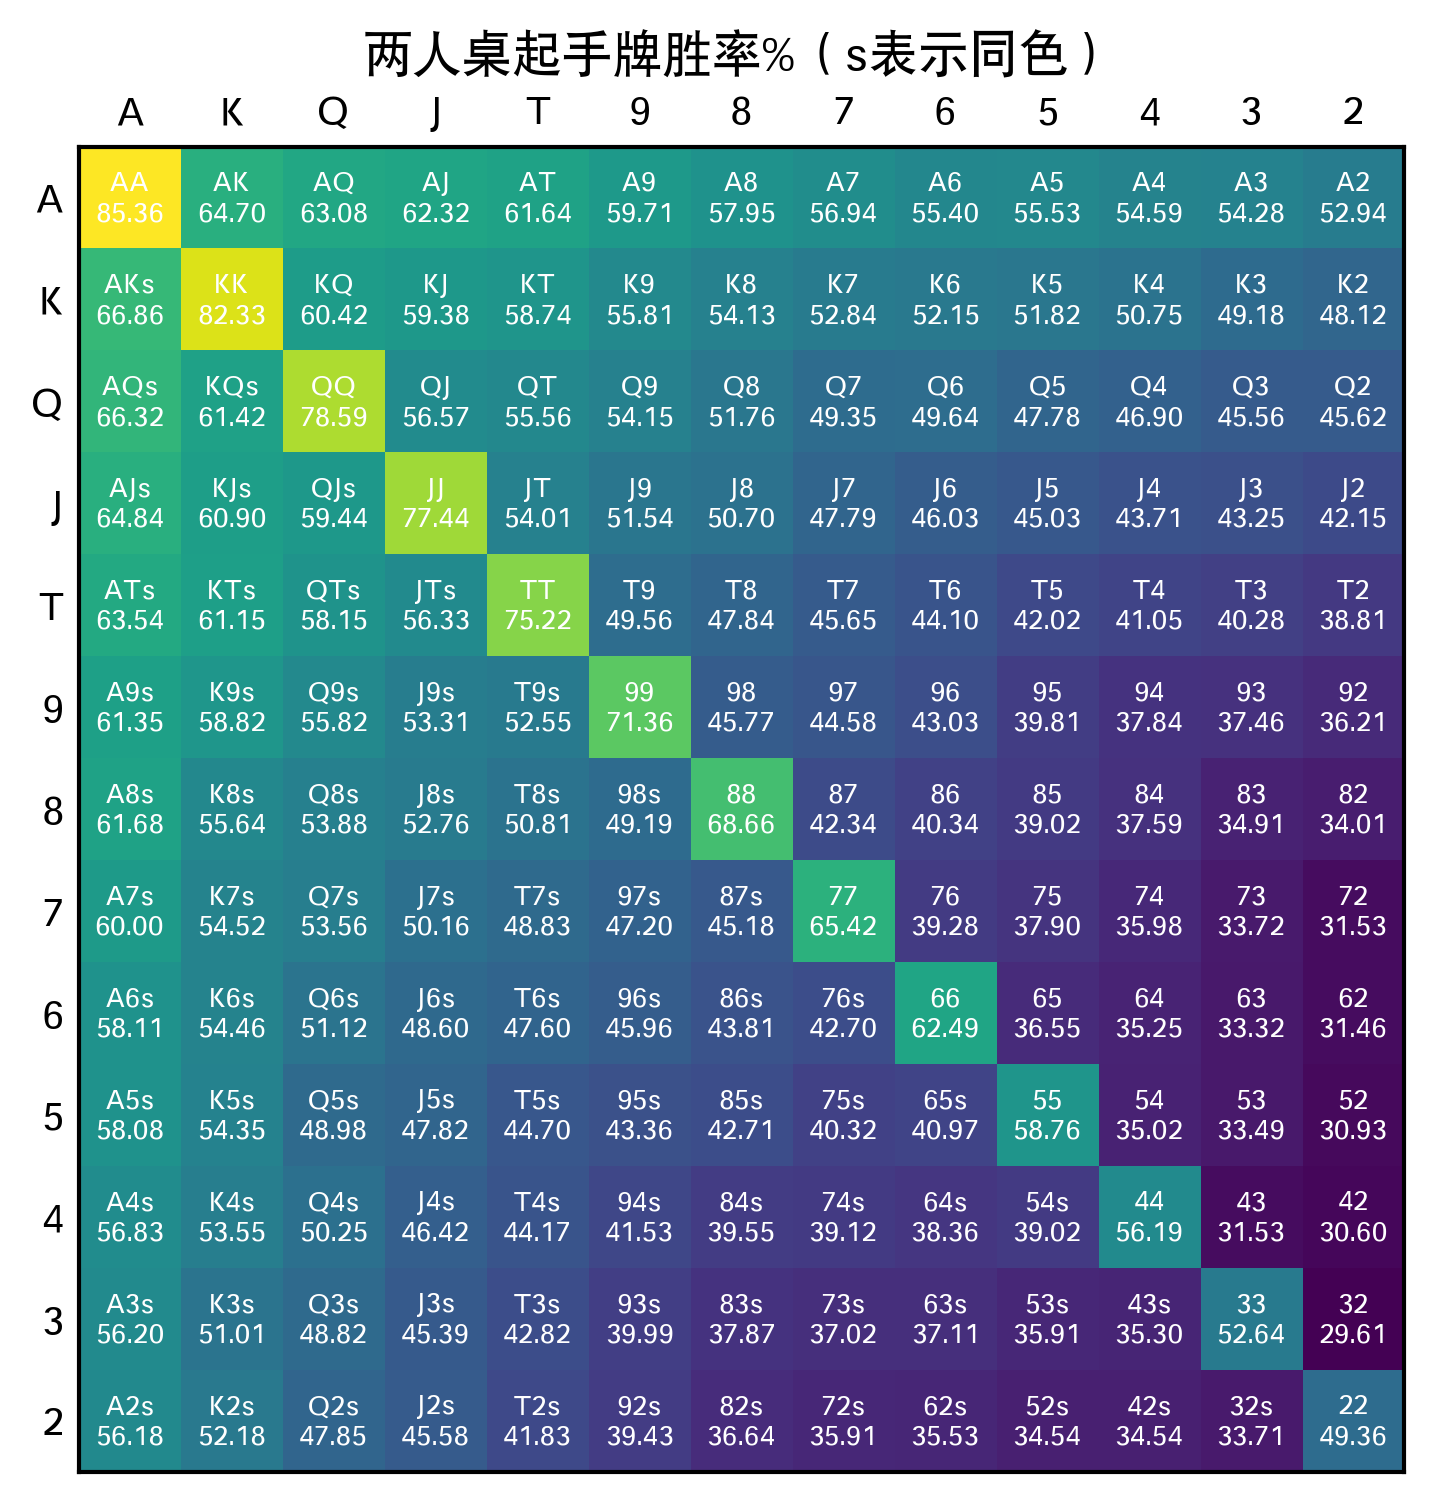

In [11]:
print(f"将两人桌起手牌胜率画成热力图")
plot_win_rate(win_rate, title="两人桌起手牌胜率%（s表示同色）", path_to_save="win_rate_2p.pdf")